# Statefarm Distracted Driver Classification (using Keras)
## Satchel Grant

The goal of this notebook is to classify the State Farm Distracted Drivers dataset using Keras. I also implement a generator for data feeding to reduce the memory consumption during training. And I practice using ThreadPool for quicker image processing during testing.

### Overview
I begin by reading in the file paths to each of the training images. The total dataset gives training images, testing images with no labels, and a sample submission csv. 

The training images are split into ten folders each denoting their image classification. I read them in and convert their classification to an integer from 0-9.

I then create a data augmentation function to make rotated and translated copies of each of the training images. This enlarges the dataset which tends to help the classification model generalize. Note, I have not used this data yet.

Next I create a generator to read in images in batches from their file names.

I then define the model in Keras. The convolutional layers each are composed of 3 different filters (1x1, 3x3, and 5x5). The filters are then each run on individually the incoming activations with 'same' padding. Each of the resulting, outgoing activations are stacked by sample. This negates the need to pick a filter size. The outgoing activations are then max pooled (2x2 filter and stride). The model then runs 2 dense layers followed by an output layer. Each convolutional and dense layer use the 'elu' activation function for its improvements on the 'relu' function except for the final outputs which use a softmax function. The model uses batchnormalization at each layer and uses dropout most extensively when switching from convolutional to dense layers. See the README.md for more details.

The model works well on the training and validation set considering its relatively small size. After a total of 12 epochs using the adam optimizer, it was producing greater than 99% accuracy on both the training and validation set without using the aumented data. Additionally, the total training was performed within 6 hours on a CPU.

I used ThreadPool for reading the testing images in concurrently with evaluating them on the model. This saved about 20 minutes on a CPU.

For the submission, I got best results by adjusting the prediction confidence to 95% and distributing the remaining 5% equally to each of the other classes. The final log loss on Kaggle was 1.8 on the private board and 2.0 on the public board. This translates to roughly 65% accuracy. Needless to say, I overfit the training and validation data. This is likely due in part to multiple pictures of the same driver in the training data. To fix this, I plan on using the augmented data and making more use of dropout. I may use fake labeling on the test set, too, which has empirical success.

### Initial Imports

In [7]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.utils import shuffle
import scipy.misc as sci
import time
import sys
from PIL import Image

%matplotlib inline

def show_img(img):
    plt.imshow(img)
    plt.show()

### Read in Data

First I read in the file paths of each of the image files. I create an array parallel to the image paths array to store the corresponding labels.


In [8]:
external_drive_path = '/Volumes/WhiteElephant/'
home_path = os.getcwd()
os.chdir(external_drive_path)

In [9]:
path = './statefarm_drivers/imgs/train'

def read_paths(path, no_labels=False):
    file_paths = []
    labels = []
    labels_to_nums = dict()
    for dir_name, subdir_list, file_list in os.walk(path):
        if len(subdir_list) > 0:
            label_types = subdir_list
            for i,subdir in enumerate(subdir_list):
                labels_to_nums[subdir] = i
        for img_file in file_list:
            if '.jpg' in img_file.lower():
                file_paths.append(os.path.join(dir_name,img_file))
                if no_labels: labels.append(img_file)
                else: labels.append(labels_to_nums[dir_name[-2:]])
    if no_labels: return file_paths, labels
    n_labels = len(label_types)
    return file_paths, labels, n_labels
    

file_paths, labels,n_labels = read_paths(path)
file_paths, labels = shuffle(file_paths, labels)

print("Number of data samples: " + str(len(file_paths)))
print("Number of Classes: " + str(n_labels))

Number of data samples: 67272
Number of Classes: 10


In [10]:
def one_hot_encode(labels, n_classes):
    one_hots = []
    for label in labels:
        one_hot = [0]*n_classes
        one_hot[label] = 1
        one_hots.append(one_hot)
    return np.array(one_hots,dtype=np.float32)

labels = one_hot_encode(labels,n_labels)

### Data Augmentation

The following cell contains data augmentation functions to increase the amount of useable data. The final aumenting function includes a rotation with random translations up to 20 pixels along both axes. The images are then saved as jpgs to be used later. The augmentation code is only meant to be used once.

The reason why I save the images instead of including them directly in the generator is that I want a random sampling of each of the drivers during batching for training. Training performance is better on completely randomized sets.

In [130]:
import random
import scipy.ndimage.interpolation as scizoom

def rotate(img, angle, ones):
    rot_img = sci.imrotate(img, angle).astype(np.float32)
    color_range = 255
    rand_filler = np.random.random(rot_img.shape).astype(np.float32)*color_range
    rot_img[ones[:,:,:]!=1] = rand_filler[ones[:,:,:]!=1]
    return rot_img

def translate(img, row_amt, col_amt):
    color_range = 255
    translation = np.random.random(img.shape).astype(img.dtype)*color_range
    if row_amt > 0:
        if col_amt > 0:
            translation[row_amt:,col_amt:] = img[:-row_amt,:-col_amt]
        elif col_amt < 0:
            translation[row_amt:,:col_amt] = img[:-row_amt,-col_amt:]
        else:
            translation[row_amt:,:] = img[:-row_amt,:]
    elif row_amt < 0:
        if col_amt > 0:
            translation[:row_amt,col_amt:] = img[-row_amt:,:-col_amt]
        elif col_amt < 0:
            translation[:row_amt,:col_amt] = img[-row_amt:,-col_amt:]
        else:
            translation[:row_amt,:] = img[-row_amt:,:]
    else:
        if col_amt > 0:
            translation[:,col_amt:] = img[:,:-col_amt]
        elif col_amt < 0:
            translation[:,:col_amt] = img[:,-col_amt:]
        else:
            return img.copy()
    return translation


def add_augmentations(paths, rot_angles=[10,-10], row_shift=20, col_shift=20):
    img = mpimg.imread(paths[0])
    ones = [sci.imrotate(np.ones_like(img),rot_angles[i]) for i in range(len(rot_angles))]
    for path in paths:
        img = mpimg.imread(path)
        for i,angle in enumerate(rot_angles):
            add_augmentation(img,path,angle,row_shift,col_shift,ones[i])

def add_augmentation(img,path,angle,row_shift,col_shift,ones):
    color_range = 255
    new_img = rotate(img,angle,ones)
    new_img = translate(new_img,random.randint(-row_shift,row_shift),random.randint(-col_shift,col_shift))
    new_img = new_img.astype(np.uint8)
    split_path = path.split('/')
    i = 1
    if angle < 0: i = 2
    split_path[-1] = 'augmented_'+ str(i)+"_"+ split_path[-1]
    new_path = '/'.join(split_path)
    jpeg = Image.fromarray(new_img)
    jpeg.save(new_path)

def random_zoom(image):
    color_range = 255
    max_zoom = 1./3.
    zoom_factor = 1 + (random.random()-0.5)*max_zoom
    while zoom_factor == 1:
        zoom_factor = 1 + (random.random()-0.5)*max_zoom
    # scipy's zoom function returns different size array
    # The following code ensures the zoomed image has same pixel size as initial image
    img_height, img_width = image.shape[:2]
    zoomed_h = round(img_height*zoom_factor)
    zoomed_w = round(img_width*zoom_factor)
    diff_h = abs(zoomed_h-img_height)
    diff_w = abs(zoomed_w-img_width)
    start_row = round(diff_h/2)
    start_col = round(diff_w/2)
    
    # Zoom in on image
    if zoom_factor > 1:
        end_row = start_row+img_height
        end_col = start_col+img_width
        zoom_img = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)[start_row:end_row,
                                                               start_col:end_col]
    # Zoom out on image
    elif zoom_factor < 1:
        temp = scizoom.zoom(image,(zoom_factor,zoom_factor,1),output=np.uint8)
        temp_height, temp_width = temp.shape[:2]
        zoom_img = np.random.random(image.shape)*color_range # Random pixels instead of black space for out zoom
        zoom_img[start_row:start_row+temp_height,
                 start_col:start_col+temp_width] = temp[:,:]
    else:
        return image.copy()
    return zoom_img.astype(np.float32)

In [80]:
add_augmentations(file_paths, row_shift=20, col_shift=20)

The following cell demonstrates what each of the image manipulations looks like on a small sample of images.



Original


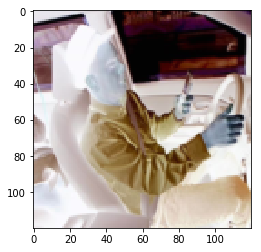


Rotated


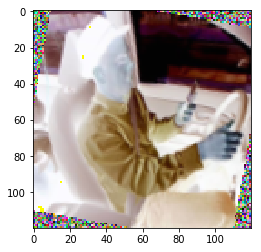


Translated


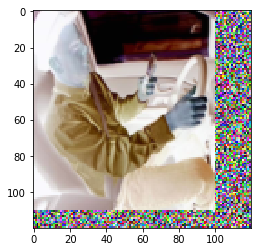


Zoomed


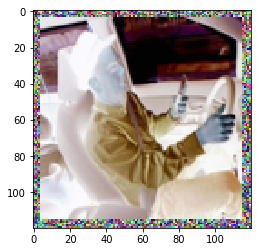



Original


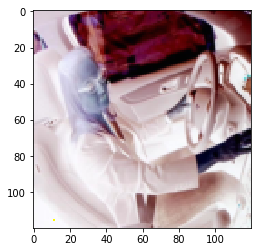


Rotated


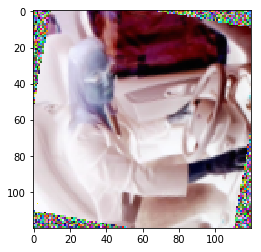


Translated


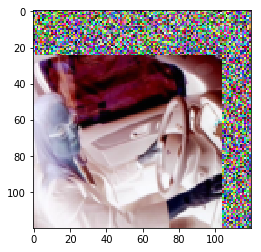


Zoomed


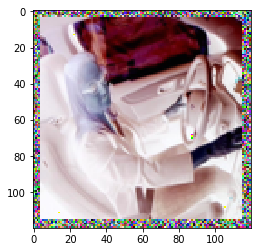



Original


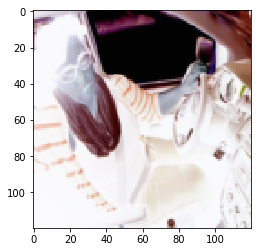


Rotated


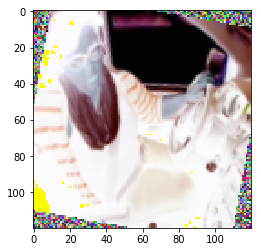


Translated


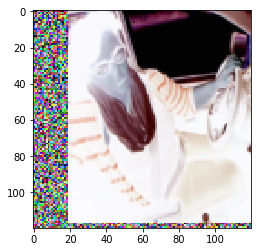


Zoomed


/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


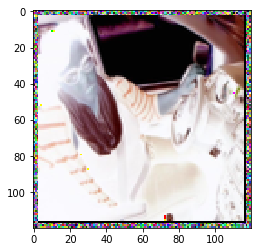



Original


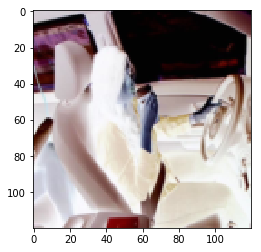


Rotated


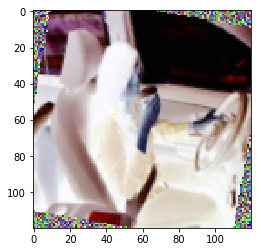


Translated


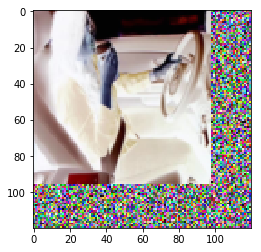


Zoomed


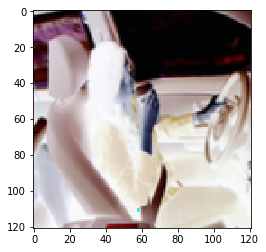



Original


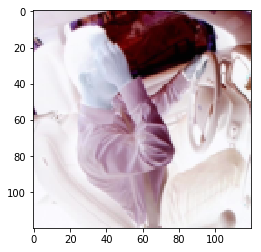


Rotated


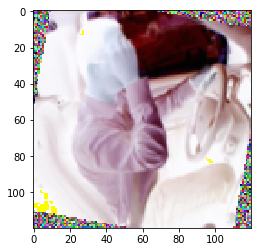


Translated


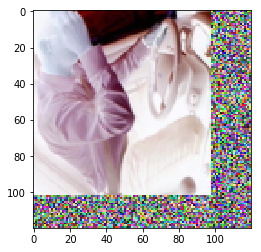


Zoomed


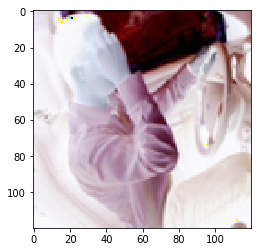



Original


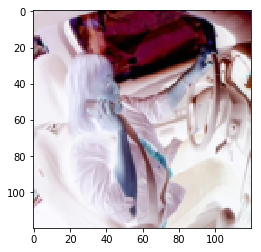


Rotated


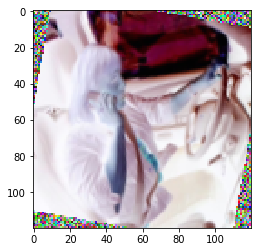


Translated


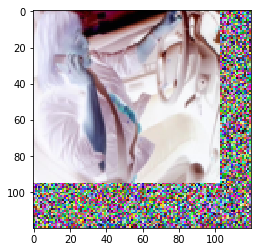


Zoomed


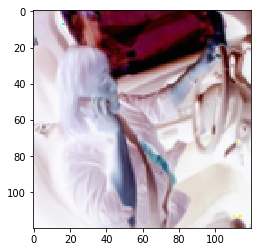

In [109]:
sample_paths = []
i = 0
while len(sample_paths) < 6 and i < len(file_paths):
    if 'augmented' not in file_paths[-i]:
        sample_paths.append(file_paths[-i])
    i += 1
samples = convert_images(sample_paths,resize_dims)
for sample in samples:
    print("\n\nOriginal")
    show_img(sample)
    print("\nRotated")
    demo = rotate(sample,-10,sci.imrotate(np.ones_like(sample.astype(np.uint8)),-10))
    show_img(demo)
    print('\nTranslated')
    demo = translate(sample, random.randint(-25,25),random.randint(-25,25))
    show_img(demo)
    print('\nZoomed')
    demo = random_zoom(sample)
    show_img(demo)


### Split the Data into Training and Validation
Ideally the validation set is a good approximator of the testing set. This allows the programmer to track progress during training and evaluate which methods help and which do not. I kept 20% of the data for validation. In this dataset, it would be best to seperate different drivers into the training and validation sets seperately. This would theoretically help the model avoid making classifications based off the driver's looks. I could not think of an easy way to split the data, however, so I randomly split it instead. I will note that this ends up reducing the use of the validation set in the long run. Later in the notebook you will see that the model classifies the validation set with >99% accuracy. It gets ~75% on the test set, however. The validation set is still useful to determine the degree of overfitting on the training set. But it's use is reduced by not being an accurate predictor of the test set.

In [ ]:
split_index = int(.8*len(file_paths)) # 20% of the data is kept as validation
X_train_paths, y_train = file_paths[:split_index], labels[:split_index]
X_valid_paths, y_valid = file_paths[split_index:], labels[split_index:]

### Image Generator
Next I create a generator to read in the images in batches for training. This reduces the necessary memory required to train on the whole dataset.

There are two functions, convert_images is used to read in the images from the paths array and image_generator is used to enforce the batch sizing and proper labeling. convert_images is used again later for the testing set.

In [131]:
def convert_images(paths, labels, resize_dims, add_zooms=False):
    images = []
    new_labels = []
    for path,label in zip(paths,labels):
        img = mpimg.imread(path)
        resized_img = sci.imresize(img, resize_dims)
        images.append(resized_img)
        if add_zooms:
            images.append(random_zoom(resized_img))
            new_labels.append(label)
            new_labels.append(label)
    if add_zooms: return np.array(images,dtype=np.float32), np.array(new_labels,dtype=np.float32)
    return np.array(images,dtype=np.float32), labels


# Marking add_zooms true will add an additional randomly zoomed image to the batch for each image already in the batch
def image_generator(file_paths, labels, batch_size, resize_dims=(120,120), add_zooms=False):
    if add_zooms: batch_size = int(batch_size/2)
    while 1:
        file_paths,labels = shuffle(file_paths,labels)
        for batch in range(0, len(file_paths), batch_size):
            images, batch_labels = convert_images(file_paths[batch:batch+batch_size], 
                                                  labels[batch:batch+batch_size], 
                                                  resize_dims, add_zooms=add_zooms)
            yield images, batch_labels



The following cell creates the training and validation generators using the functions above.

In [ ]:
batch_size = 128
add_training_zooms = True


n_train_samples = len(X_train_paths)
if add_training_zooms: n_train_samples = 2*len(X_train_paths)

train_steps_per_epoch = n_train_samples//batch_size + 1
if n_train_samples % batch_size == 0: train_steps_per_epoch = n_train_samples//batch_size

valid_steps_per_epoch = len(X_valid_paths)//batch_size
resize_dims = (120,120)


train_generator = image_generator(X_train_paths, y_train, batch_size, add_zooms=add_training_zooms)
valid_generator = image_generator(X_valid_paths, y_valid, batch_size)

### Pseudo Labeling
This is a semi-suprevised learning technique that I find fascinating. The idea is to use the test data as training data by using the predictions of the test data as the labels. This is a crazy idea. The theory is that the classifier can determine certain structures in the pseudo-labeled data to help it make classifications. Some big questions are, how much pseudo labeling should be included in each epoch? Each batch? At what test set accuracies does pseudo labeling work? What types of datasets lend themselves more readily to pseudo labeling? I don't really know the answers to these questions, so, I obviously still don't understand how it fully works. But it empirically improves predictions so I am including it in this notebook.

In [154]:
predictions = []
with open('statefarm_drivers/submission.csv', 'r') as f:
    for i,line in enumerate(f):
        if i == 0: continue
        split_line = line.strip().split(',')[1:]
        prediction = [0 if float(x) < 0.9 else 1 for x in split_line]
        predictions.append(prediction)


In [156]:
def pseudo_generator(paths, labels, pseudo_paths, pseudo_labels, batch_size, pseudo_fraction=1/3., add_zooms=False):
    # paths are the labeled image paths, labels are the labels for the labeled images
    # pseudo_paths are the unlabeled image paths, pseudo_labels are the model predictions for the unlabeled images
    # batch_size is the size of the generated images and labels
    # pseudo_fraction is the fraction of pseudo labeled images in each batch
    if add_zooms: batch_size = int(batch_size/2)
    pseudo_batch_size = batch_size*pseudo_fraction
    labeled_batch_size = batch_size-pseudo_batch_size
    while True:
        paths, labels = shuffle(paths, labels)
        pseudo_paths, pseudo_labels = shuffle(pseudo_paths, pseudo_labels)
        for batch in range(0,len(paths),batch_size):
            images, batch_labels = convert_images(paths[batch:batch+batch_size]+pseudo_paths[batch:batch+batch_size],
                                                  np.concatenate((labels[batch:batch+batch_size],pseudo_labels[batch:batch+batch_size]),axis=0),
                                                  resize_dims, add_zooms=add_zooms)
            yield images, batch_labels
            
pseudo_gen = pseudo_generator(X_train_paths,y_train,test_paths,predictions, batch_size)

### Keras Imports

In [12]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, concatenate, \
        Flatten, Dropout, Lambda
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


### Model Architecture

The model consists of 4 convolutional stacks followed by 2 dense layers and a final output layer. I had good success with this model while predicting the required steering angle from an image of a track for a car to drive around a track in real time. It is also a lightweight model making it quick and easy to train.


In [44]:
stacks = []
conv_shapes = [(1,1),(3,3),(5,5)]
conv_depths = [8,10,10,10]
pooling_filter = (2,2)
pooling_stride = (2,2)
dense_shapes = [150,50,n_labels]

inputs = Input(shape=(resize_dims[0],resize_dims[1],3))
zen_layer = BatchNormalization()(inputs)

for shape in conv_shapes:
    stacks.append(Conv2D(conv_depths[0], shape, padding='same', activation='elu')(inputs))
layer = concatenate(stacks,axis=-1)
layer = BatchNormalization()(layer)
layer = MaxPooling2D(pooling_filter,strides=pooling_stride,padding='same')(layer)
layer = Dropout(0.05)(layer)

for i in range(1,len(conv_depths)):
    stacks = []
    for shape in conv_shapes:
        stacks.append(Conv2D(conv_depths[i],shape,padding='same',activation='elu')(layer))
    layer = concatenate(stacks,axis=-1)
    layer = BatchNormalization()(layer)
    layer = Dropout(i*10**-2+.05)(layer)
    layer = MaxPooling2D(pooling_filter,strides=pooling_stride, padding='same')(layer)

layer = Flatten()(layer)
layer = Dropout(0.55)(layer)

for i in range(len(dense_shapes)-1):
    layer = Dense(dense_shapes[i], activation='elu')(layer)
    layer = BatchNormalization()(layer)

outputs = Dense(dense_shapes[-1], activation='softmax')(layer)

### Training and Validation
The next cell trains the model using the adam optimizer and categorical_crossentropy. The adam optimizer is most efficient because it has specific learning rates for each parameter in the net and it uses momentum. Both of these techniques improves the efficiency of the training process.

I use the categorical_crossentropy loss function because this a good loss function for classification problems.

#### Regular Training

In [148]:
model = Model(inputs=inputs,outputs=outputs)
model.load_weights('model.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                    validation_data=valid_generator,validation_steps=valid_steps_per_epoch)
model.save('model.h5')


Epoch 1/1


/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


841/841 [==============================] - 11911s - loss: 0.0706 - acc: 0.9773 - val_loss: 0.0223 - val_acc: 0.9926

#### Training with Pseudo Labeling

In [ ]:
model = Model(inputs=inputs,outputs=outputs)
model.load_weights('pseudo_model.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(train_generator, train_steps_per_epoch, epochs=1,
                    validation_data=valid_generator,validation_steps=valid_steps_per_epoch)
model.save('pseudo_model.h5')

Epoch 1/1


/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


131/841 [===>..........................] - ETA: 8919s - loss: 0.0565 - acc: 0.9800 

### Collecting Predictions
The following cells are for testing on the unlabeled dataset. Similar to the training images, I first read in the image paths. I then create a seperate process for reading in the images using ThreadPool. The images are read in while the model evaluates the samples.

In [133]:
path = './statefarm_drivers/imgs/test'
test_paths, test_labels = read_paths(path,no_labels=True)
print(str(len(test_paths))+' testing images')

79726 testing images


In [142]:
from multiprocessing.pool import ThreadPool
pool = ThreadPool(processes=1) # Creates new process
test_divisions = 20
portion = len(test_paths)//test_divisions+1 # Size of portion of images to read in
async_result = pool.apply_async(convert_images,(test_paths[0*portion:portion*(0+1)], 
                                                test_labels[0*portion:portion*(0+1)],resize_dims))
predictions = []
batch_size = 100 # Batch size used for keras predict function

In [143]:
total_base_time = time.time()

for i in range(1,test_divisions+1):
    base_time = time.time()
    
    print("Begin set " + str(i))
    X_set,_ = async_result.get()
    
    if i < test_divisions:
        async_result = pool.apply_async(convert_images,(test_paths[i*portion:portion*(i+1)],
                                                        test_labels[0*portion:portion*(0+1)],resize_dims))
        
    predictions.append(model.predict(X_set,batch_size=batch_size,verbose=0))
    
#     print("Execution Time: " + str((time.time()-base_time)/60)+'min\n')
predictions = np.reshape(predictions, (-1,n_labels))
print("Total Execution Time: " + str((time.time()-total_base_time)/60)+'mins')

Begin set
Finish reading images, time: 57.46773815155029secs
Execution Time: 3.882257966200511min

Begin set
Finish reading images, time: 0.054518938064575195secs
Execution Time: 2.9273372014363606min

Begin set
Finish reading images, time: 0.055123090744018555secs
Execution Time: 2.9337401509284975min

Begin set
Finish reading images, time: 0.05399608612060547secs
Execution Time: 2.998496333758036min

Begin set
Finish reading images, time: 0.05891704559326172secs
Execution Time: 2.9734108010927836min

Begin set
Finish reading images, time: 0.05701899528503418secs
Execution Time: 2.939392117659251min

Begin set
Finish reading images, time: 0.05495405197143555secs
Execution Time: 2.9340148170789084min

Begin set
Finish reading images, time: 0.058032989501953125secs
Execution Time: 2.9437110304832457min

Begin set
Finish reading images, time: 0.06948184967041016secs
Execution Time: 2.9581779837608337min

Begin set
Finish reading images, time: 0.0848689079284668secs
Execution Time: 2.9597

The next cell verifies that the number of predictions is equal to the number of images in the test set.

In [151]:
print("Number of Images: " + str(len(test_paths)))
print("Number of predictions: " + str(predictions.shape[0]))
if len(test_paths) == predictions.shape[0]: print("Success!")
else: print("Failure")

Number of Images: 79726
Number of predictions: 2
Failure


### Submitting Predictions
The loss format for kaggle is the negative sum of the logs of the confidences for the correct prediction.

loss = sum(log(correct class confidence))/num_samples for each correct class. 

This means that a high confidence on a correct prediction is minimally penalized whereas a low confidence on the correct prediction is maximally penalized.

The following cell sets a confidence for the predicted class. The remaining confidence out of 1 is equally distributed to the other 9 classes.

In [145]:
confidence = .95
for i,prediction in enumerate(predictions):
    max_index = 0
    for j in range(1,len(prediction)):
        if prediction[j] > prediction[max_index]: max_index = j
    predictions[i][max_index] = confidence
    for j in range(len(prediction)):
        if j != max_index: predictions[x][i][j] = (1-confidence)/(len(prediction)-1)

The following cell writes the predictions to a csv file in the format specified by the sample_submission.csv from kaggle.

In [146]:
counter = 0
with open('./statefarm_drivers/submission.csv', 'w') as f:
    f.write('img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n')
    for i,logit in enumerate(predictions):
        id_ = test_labels[i]
        f.write(id_+',')
        for j,element in enumerate(logit):
            if j == logit.shape[0]-1: f.write(str(element)+'\n')
            else: f.write(str(element)+',')

This submission got a 1.3 log loss on the private leader board and a 1.5 on the public leader board. Since I do not know exactly the sizes of the private and public portions of the data, it is difficult to know how accurate this set of predictions is.

loss = 1/num_total_images x (num_correct_predictions x log(confidence) + 
                            num_wrong_predictions x log((1-confidence)/(n_classes-1)))

loss x n = num_right x log(confidence) + num_wrong x log((1-confidence)/(n_classes-1))

The following cell tries different accuracies to approximate the accuracy on the test set. I use the arbitrary assumption that the public data makes up 2/3 of the test images while the private data is 1/3 of the test images.

In [147]:
import math

public_loss = 1.44849
public_portion = 2/3
private_loss = 1.19418
private_portion = 1-public_portion

loss = (public_loss*public_portion + private_loss*private_portion)*len(predictions)
accuracy = 0.1
calculated_loss = 0
while (calculated_loss-loss)**2 > 10 and accuracy <= 1:
    accuracy += .0000001
    num_right = int(len(predictions)*accuracy)
    num_wrong = len(predictions)-num_right
    calculated_loss = -(num_right*math.log(confidence) + num_wrong*math.log((1-confidence)/(n_classes-1)))
print("Actual loss: " + str(loss))
print("Calculated loss: " + str(calculated_loss))
print("Accuracy: " + str(accuracy*100) + '%')
    


Actual loss: 27.2744
Calculated loss: 26.734183670264304
Accuracy: 75.00000998799132%


Assuming these calculations are correct, the model got an overall accuracy of around 75%... This means the model severly overfitted. To fix this, I will try more extensive use of data augmentation and dropout.